In [1]:
import numpy as np
import pandas as pd
from spec_id import RT_spec,Gen_spec, Analyze_LH,Median_w_Error_cont,Oldest_galaxy
import matplotlib.pyplot as plt
from astropy.cosmology import Planck13, z_at_value
from astropy.table import Table
from astropy.io import fits
import astropy
from astropy import units as u
from astropy.cosmology import WMAP9 as cosmo
import os
import cPickle
import seaborn as sea
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({"xtick.direction": "in","ytick.direction": "in"})
colmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.1, as_cmap=True)

In [2]:
lam = np.logspace(1, 6)

In [4]:
nu = 3E18/lam

In [8]:
lognu = np.log10(nu)

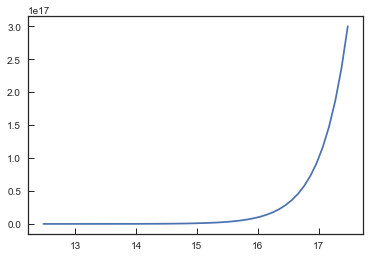

In [9]:
%matplotlib inline

plt.plot(lognu,nu)
plt.show()
plt.close()